In [1]:
import sys
sys.path.append('../src/')
del sys

In [2]:
import dataclasses
import math

import jax
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt
import matplotlib as mpl

from event2vec.util import tril_to_matrix, matrix_to_tril, ConstituentModel
from event2vec.nontrainable import StandardScalerWrapper
from event2vec.datasets import VBFHDataset
from event2vec.training import TrainingConfig
from event2vec.experiment import run_experiment

import treescope
treescope.basic_interactive_setup()

In [3]:
class FrobeniusNormLoss:
    def __call__(self, model, data, *, key=None):
        pred_matrix = jax.vmap(model.matrix_pred)(data.observables)
        pred_latent = matrix_to_tril(pred_matrix)
        
        true_latent = data.latent_data

        n = pred_matrix.shape[-1]
        il = jnp.tril_indices(n)

        diag_indices = [int(i*(i+3)/2) for i in range(n)]
        
        return 0.5*(
            ((pred_latent - true_latent)**2)
            .at[..., diag_indices]
            .multiply(2)
        ).sum(axis=-1).mean()

In [4]:
class PositiveDefiniteMatrix(eqx.Module):
    n: int
    "Dimensionality of the matrix"
    
    model: ConstituentModel
    "A trainable model that maps the input observables to an n^2 dimensional vector"

    def matrix_pred(self, observables):
        A = self.model(observables).reshape(self.n, self.n)

        return A.T @ A

In [5]:
@dataclasses.dataclass
class ModelConfig:
    output_shape: tuple[int]
    width: int
    depth: int

    def build(self, key, training_data):
        print(math.prod(self.output_shape))
        """Build the model from the configuration."""
        model = eqx.nn.MLP(
            in_size=training_data.observable_dim,
            out_size=math.prod(self.output_shape),
            width_size=self.width,
            depth=self.depth,
            activation=jax.nn.leaky_relu,
            # final_activation=lambda vec: jnp.reshape(vec, self.output_shape),
            key=key,
        )
        
        model = StandardScalerWrapper.build(
            model=model,
            data=training_data.observables,
        )
        
        return PositiveDefiniteMatrix(self.output_shape[0], model)

In [6]:
data = VBFHDataset.from_lhe("../data/smeftsim_VBFH-*.lhe.gz")

Output()

LHE weight fit residuals mean: 1.2227341535109293e-12 std: 7.60633092969365e-13


/home/prasanth/prasanth@WSL/Research/event2vec_4_EFT/github_repo/event2vec/notebook/../src/event2vec/datasets/lhedataset.py:247: UserWarning: Coefficient matrix is not positive semi-definite, negative eigenvalues: [-6.8273484e-06]
  latent_norm = QuadraticFormNormalization.from_coefficients(


In [7]:
data.likelihood(jnp.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]))

Array([0.99999946, 0.9999995 , 0.9999996 , ..., 0.99999934, 0.9999997 ,
       0.99999946], dtype=float32)

In [8]:
def data_factory(key):
    return data

train_config = TrainingConfig(
    test_fraction=0.50,
    batch_size=1024,
    learning_rate=0.01,
    epochs=250,
    loss_fn=FrobeniusNormLoss()
)

model_config = ModelConfig(
    output_shape=(6,6),
    width=512,
    depth=6
)

In [9]:
key = jax.random.PRNGKey(41)

data_key, model_key, train_key = jax.random.split(key, 3)

data = data_factory(key=data_key)
untrained_model = model_config.build(key=model_key, training_data=data)

36


In [10]:
key = jax.random.PRNGKey(41)

model, data, loss_train, loss_test = run_experiment(
    data_factory, model_config, train_config, key=key
)

36


Output()

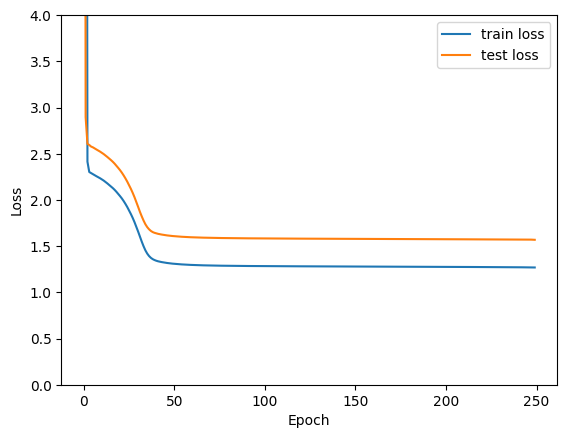

In [11]:
fig, ax = plt.subplots()

ax.plot(loss_train, label="train loss")
ax.plot(loss_test, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim(0, 4)
ax.legend()

In [12]:
latent_matrix = tril_to_matrix(data.latent_data)

In [13]:
pred_matrix_before_training = jax.vmap(untrained_model.matrix_pred)(data.observables)
pred_matrix = jax.vmap(model.matrix_pred)(data.observables)

In [14]:
avg_latent_matrix = jnp.mean(latent_matrix, axis=0)

In [15]:
eigvals, eigvectors = jnp.linalg.eigh(avg_latent_matrix)

In [16]:
latent_lengths = []
pred_lengths = []
pred_lengths_before_training = []

for i in range(6):
    latent_lengths.append(jnp.sum(jnp.sum(latent_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths.append(jnp.sum(jnp.sum(pred_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths_before_training.append(jnp.sum(jnp.sum(pred_matrix_before_training * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))

latent_lengths = jnp.array(latent_lengths)
pred_lengths = jnp.array(pred_lengths)
pred_lengths_before_training = jnp.array(pred_lengths_before_training)

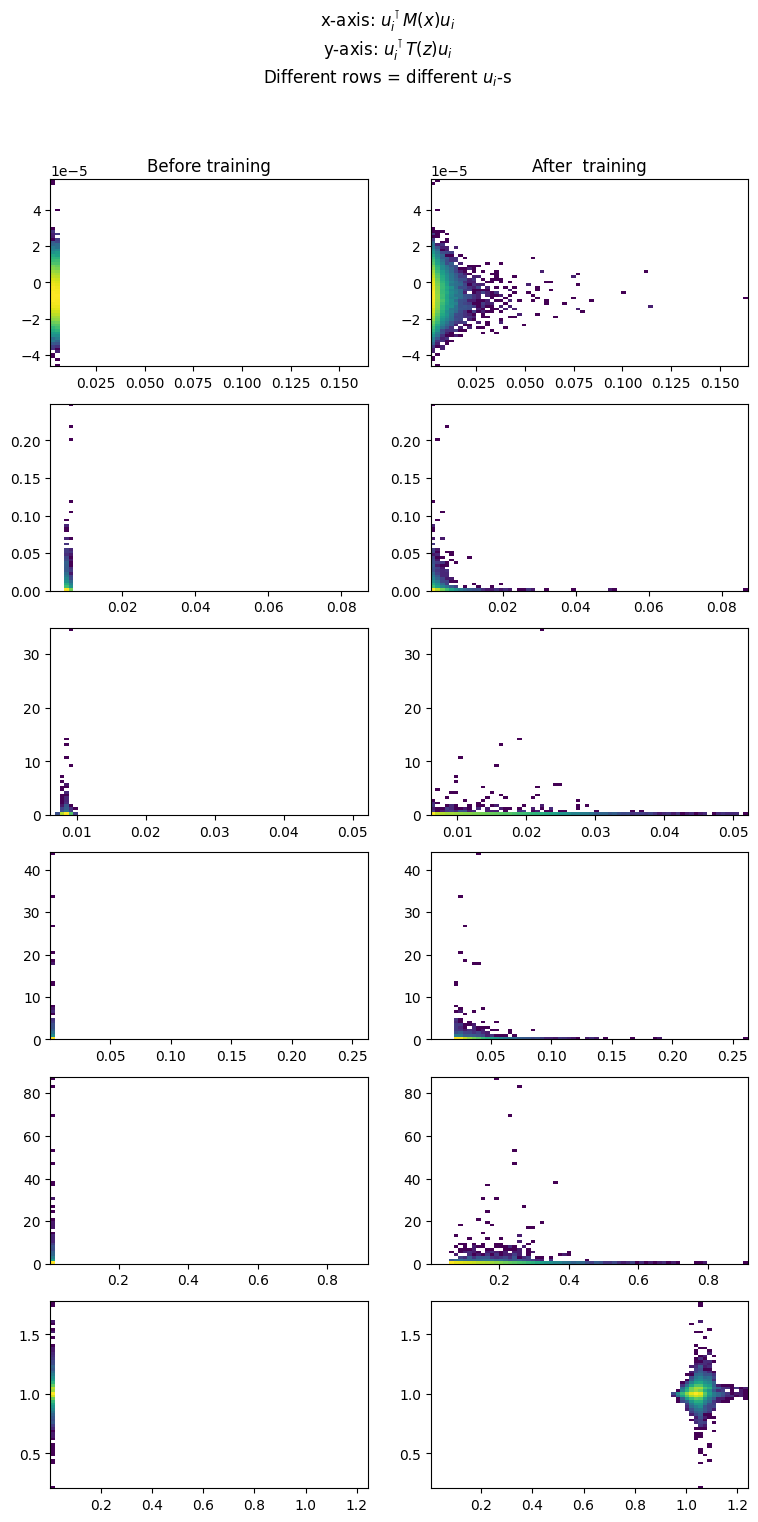

In [17]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(pred_lengths[i]), jnp.min(pred_lengths_before_training[i]))
    x_hi = max(jnp.max(pred_lengths[i]), jnp.max(pred_lengths_before_training[i]))

    y_lo = jnp.min(latent_lengths[i])
    y_hi = jnp.max(latent_lengths[i])
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(pred_lengths_before_training[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(pred_lengths[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $u_i^\\intercal M(x) u_i$ \ny-axis: $u_i^\\intercal T(z) u_i$\nDifferent rows = different $u_i$-s")

None

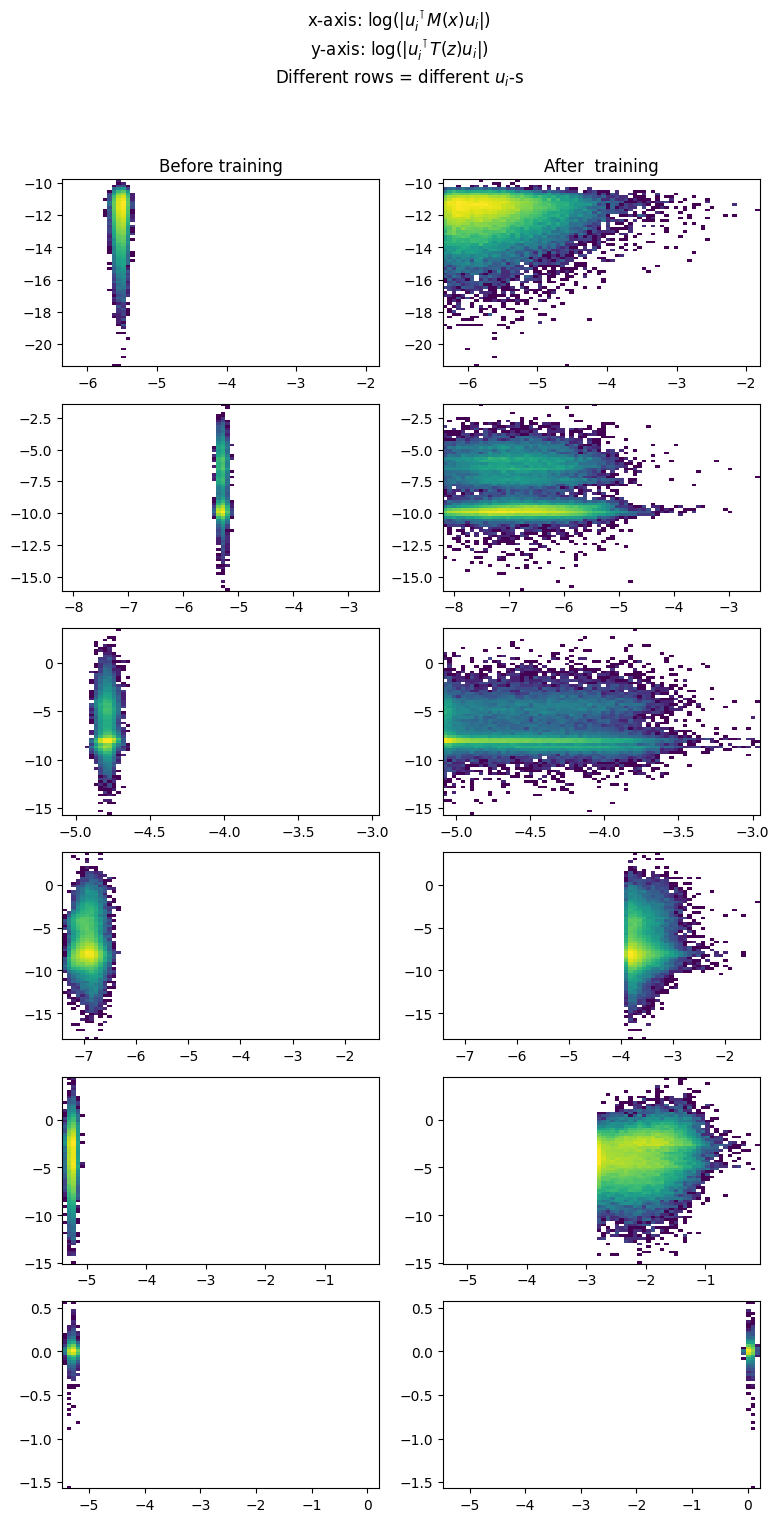

In [18]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(jnp.log(jnp.abs(pred_lengths[i]))), jnp.min(jnp.log(jnp.abs(pred_lengths_before_training[i]))))
    x_hi = max(jnp.max(jnp.log(jnp.abs(pred_lengths[i]))), jnp.max(jnp.log(jnp.abs(pred_lengths_before_training[i]))))

    y_lo = jnp.min(jnp.log(jnp.abs(latent_lengths[i])))
    y_hi = jnp.max(jnp.log(jnp.abs(latent_lengths[i])))
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(jnp.log(jnp.abs(pred_lengths_before_training[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(jnp.log(jnp.abs(pred_lengths[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $\\log(|u_i^\\intercal M(x) u_i|)$ \ny-axis: $\\log(|u_i^\\intercal T(z) u_i|)$\nDifferent rows = different $u_i$-s")

None

In [19]:
avg_pred_matrix_before_training = pred_matrix_before_training.mean(axis=0)
avg_pred_matrix = pred_matrix.mean(axis=0)

In [20]:
jnp.linalg.eigvals(avg_latent_matrix - avg_pred_matrix_before_training)

Array([ 1.0022143 +0.j,  0.12038042+0.j,  0.02350423+0.j, -0.00869618+0.j,
        0.00528013+0.j, -0.0017383 +0.j], dtype=complex64)

In [21]:
jnp.linalg.eigvals(avg_latent_matrix - avg_pred_matrix)

Array([-0.04040005+0.j,  0.00464687+0.j, -0.00525367+0.j, -0.00316086+0.j,
        0.00037987+0.j, -0.00119718+0.j], dtype=complex64)

In [27]:
input_shape = data.observables.shape[1:]
latent_shape = data.latent_data.shape[1:]

input_dim = math.prod(input_shape)

assert len(latent_shape) == 1
param_dim = int((jnp.sqrt(8 * latent_shape[0] + 1) - 1) / 2)

print(f"{input_shape = }\n{param_dim = }")

input_shape = (13,)
param_dim = 6


In [28]:
param_mean = jnp.zeros(param_dim).at[0].set(1)
param_cov = (jnp.eye(param_dim).at[0,0].set(0)) * 0.1

In [29]:
alt_param = jnp.ones(6).at[1:].set(
    jax.random.multivariate_normal(key=jax.random.key(0), mean=param_mean[1:], cov=param_cov[1:,1:])
)
print(alt_param)

[ 1.          0.5131245   0.64044493 -0.1371146  -0.02486099  0.05568483]


In [30]:
true_alt_reweights = jnp.sum(latent_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))
pred_alt_reweights = jnp.sum(pred_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))

alt_param.tolist() = [1.0, 0.5131245255470276, 0.6404449343681335, -0.13711459934711456, -0.024860989302396774, 0.055684830993413925]


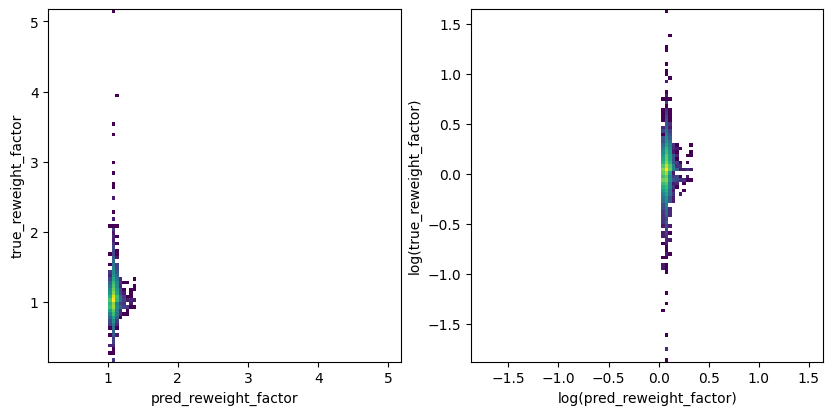

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

lo = min(jnp.min(pred_alt_reweights), jnp.min(true_alt_reweights))
hi = max(jnp.max(pred_alt_reweights), jnp.max(true_alt_reweights))

axes[0].hist2d(pred_alt_reweights, true_alt_reweights, range=((lo, hi), (lo, hi)), bins=100, norm=mpl.colors.LogNorm())
axes[1].hist2d(jnp.log(pred_alt_reweights), jnp.log(true_alt_reweights), range=jnp.log(jnp.array(((lo, hi), (lo, hi)))), bins=100, norm=mpl.colors.LogNorm())

for ax in axes:
    ax.set_aspect('equal')

axes[0].set_xlabel('pred_reweight_factor')
axes[0].set_ylabel('true_reweight_factor')

axes[1].set_xlabel('log(pred_reweight_factor)')
axes[1].set_ylabel('log(true_reweight_factor)')

print(f"{alt_param.tolist() = }")

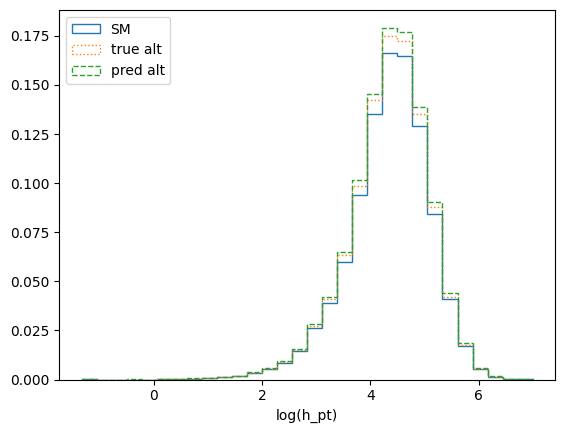

In [32]:
fig, ax = plt.subplots()

log_h_pt = data.observables[:,0]

bins=30
num_events = len(data.observables)

ax.hist(log_h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("log(h_pt)")

ax.legend(loc=2)

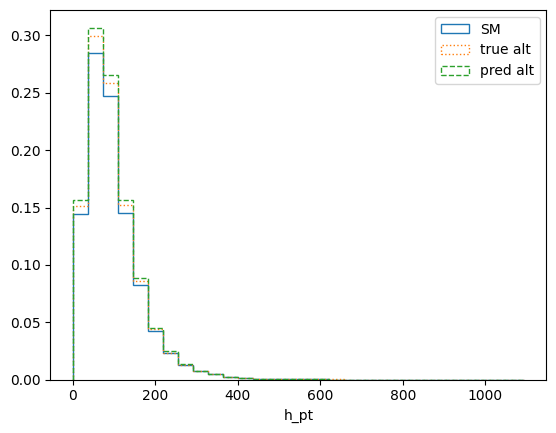

In [33]:
fig, ax = plt.subplots()

h_pt = jnp.exp(data.observables[:,0])

bins=30
num_events = len(data.observables)

ax.hist(h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("h_pt")

ax.legend(loc=1)